# Checking out George's annotatoins for song vs. not-song segments

In [3]:
import numpy as np

def print_npz_contents(npz_path: str):
    with np.load(npz_path, allow_pickle=True) as archive:
        keys = archive.files
        print(f"Found {len(keys)} item(s) in '{npz_path}':\n")
        for key in keys:
            print(f"--- {key} ---")
            print(archive[key], "\n")

# now simply do:
npz_path = "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/train/llb3_0010_2018_04_23_15_03_45_segment_0.npz"
print_npz_contents(npz_path)


Found 4 item(s) in '/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/train/llb3_0010_2018_04_23_15_03_45_segment_0.npz':

--- s ---
[[-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 ...
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]
 [-80. -80. -80. ... -80. -80. -80.]] 

--- vocalization ---
[1 1 1 ... 1 1 1] 

--- labels ---
[0 0 0 ... 0 0 0] 

--- song ---
[0 0 0 ... 0 0 0] 



In [7]:
import numpy as np

def print_npz_uniques(npz_path: str):
    """
    Load a .npz archive and for each stored array, print its name,
    its shape, the number of unique values, and the unique values themselves.
    """
    with np.load(npz_path, allow_pickle=True) as archive:
        for key in archive.files:
            arr = archive[key]
            uniques = np.unique(arr)
            print(f"--- {key} ---")
            print(f"shape: {arr.shape}")
            print(f"{uniques.size} unique value(s):")
            print(uniques)
            print()  # blank line

# Example usage:
npz_path = "/Volumes/my_own_SSD/UO_stuff/george_annotated_song/labeled_song_dataset/train/llb3_0010_2018_04_23_15_03_45_segment_0.npz"
print_npz_uniques(npz_path)


--- s ---
shape: (513, 7242)
1050556 unique value(s):
[-80.         -79.99998695 -79.99995055 ...  -0.27609419  -0.24555431
   0.        ]

--- vocalization ---
shape: (7242,)
1 unique value(s):
[1]

--- labels ---
shape: (7242,)
1 unique value(s):
[0]

--- song ---
shape: (7242,)
2 unique value(s):
[0 1]



### Let's see what the spectrogram looks like:

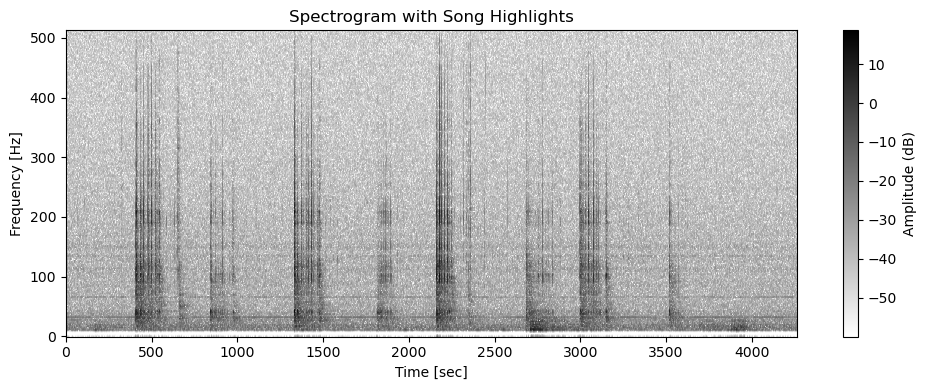

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def plot_spectrogram_with_song_highlight(npz_path: str):
    """
    Load a .npz file containing:
      - 's': spectrogram amplitude (shape: [n_freqs, n_times])
      - 'f': optional frequency bins
      - 't': optional time bins
      - 'songs': binary mask (0/1) for song presence per time bin
    and plot the spectrogram with yellow highlighted song segments,
    using the 'binary' colormap.
    """
    # Load data
    with np.load(npz_path, allow_pickle=True) as data:
        s = data['s']
        f = data['f'] if 'f' in data.files else np.arange(s.shape[0])
        t = data['t'] if 't' in data.files else np.arange(s.shape[1])
        songs = data['song'].astype(bool)

    # Detect contiguous song intervals
    padded = np.concatenate(([False], songs, [False]))
    diff = np.diff(padded.astype(int))
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]

    # Plot spectrogram with 'binary' colormap
    plt.figure(figsize=(10, 4))
    mesh = plt.pcolormesh(t, f, s, shading='auto', cmap='binary')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram with Song Highlights')
    cbar = plt.colorbar(mesh)
    cbar.set_label('Amplitude (dB)' if s.dtype.kind == 'f' else 'Power')

    # Overlay song segments
    for start, end in zip(starts, ends):
        plt.axvspan(t[start], t[end-1], color='yellow', alpha=0.1)

    plt.tight_layout()
    plt.show()

# Example usage:
npz_path = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/USA5283_45355.57012039_3_4_15_50_12_segment_0.npz"
plot_spectrogram_with_song_highlight(npz_path)



# Calculate the periodicity for one .npz file:

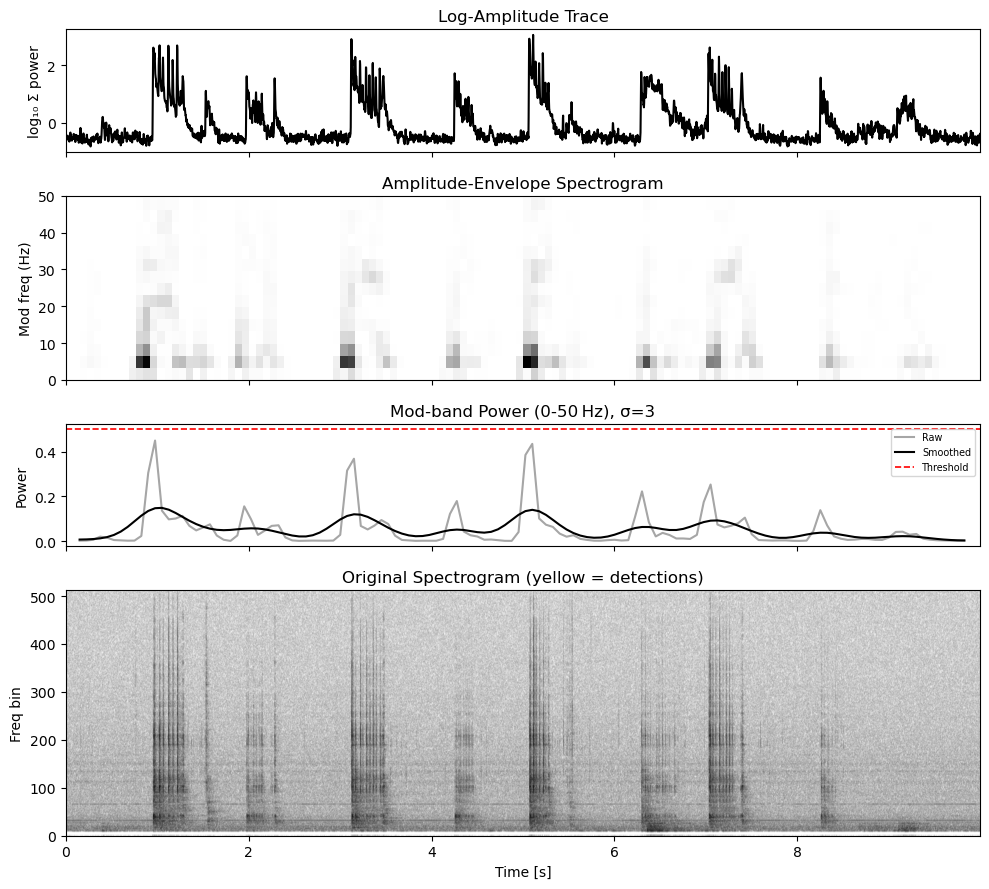

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d

# ---------------------------------------------------------------------
# CONFIG – tweak these as desired
# ---------------------------------------------------------------------
FILE_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/USA5283_45355.57012039_3_4_15_50_12_segment_0.npz"

segment_duration = 10          # seconds the original pipeline used per segment
mod_low, mod_high = 0, 50      # modulation‑frequency band (Hz)
smoothing_sigma = 3            # σ for Gaussian smoothing of the power trace
power_threshold = 0.5          # detection threshold (arbitrary units)

# ---------------------------------------------------------------------
# Load the pre‑computed spectrogram
# ---------------------------------------------------------------------
with np.load(FILE_PATH, allow_pickle=True) as npz:
    S_db = npz["s"]          # pre‑computed spectrogram in dB (shape: [freq, time])

# We do not have explicit frequency/time vectors; reconstruct a *relative* axis.
n_freqs, n_times = S_db.shape
time_axis = np.linspace(0, segment_duration, n_times, endpoint=False)
freq_axis = np.arange(n_freqs)               # “bin index” – no absolute Hz available

# Convert dB → linear power, then build a log‑amplitude trace
S_lin   = 10 ** (S_db / 10)
eps     = np.finfo(float).eps
log_amp = np.log10(S_lin.sum(axis=0) + eps)

# ---------------------------------------------------------------------
# Envelope‑spectrogram of the amplitude trace
# ---------------------------------------------------------------------
amp_fs = len(time_axis) / segment_duration   # samples / second for the amplitude trace
nper   = 128
nover  = 96
f_env, t_env, S_env = spectrogram(
    log_amp,
    fs=amp_fs,
    window="hann",
    nperseg=nper,
    noverlap=nover,
)

# Modulation‑band raw & smoothed power
mod_mask   = (f_env >= mod_low) & (f_env <= mod_high)
raw_power  = S_env[mod_mask, :].sum(axis=0)
smooth_pow = gaussian_filter1d(raw_power, sigma=smoothing_sigma)

# ---------------------------------------------------------------------
# Plotting – stack four synced panels
# ---------------------------------------------------------------------
fig, axs = plt.subplots(
    4, 1, figsize=(10, 9), sharex=True,
    gridspec_kw=dict(height_ratios=[1, 1.5, 1, 2])
)

# 1) Log‑amplitude trace
axs[0].plot(time_axis, log_amp, color="black")
axs[0].set_ylabel("log₁₀ Σ power")
axs[0].set_title("Log‑Amplitude Trace")

# 2) Envelope‑spectrogram of the trace
im1 = axs[1].imshow(
    S_env,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], f_env[0], f_env[-1]],
    cmap="binary",
)
axs[1].set_ylim(0, mod_high)
axs[1].set_ylabel("Mod freq (Hz)")
axs[1].set_title("Amplitude‑Envelope Spectrogram")

# 3) Raw & smoothed modulation‑band power
axs[2].plot(t_env, raw_power,   color="grey",  alpha=0.7, label="Raw")
axs[2].plot(t_env, smooth_pow,  color="black",            label="Smoothed")
axs[2].axhline(power_threshold, color="red", ls="--", lw=1.2, label="Threshold")
axs[2].set_ylabel("Power")
axs[2].set_title(
    f"Mod‑band Power ({mod_low}-{mod_high} Hz), σ={smoothing_sigma}"
)

# Highlight detections
detect = smooth_pow > power_threshold
in_span = False
for idx, flag in enumerate(detect):
    if flag and not in_span:
        in_span, t_start = True, t_env[idx]
    elif not flag and in_span:
        for ax in (axs[2], axs[3]):
            ax.axvspan(t_start, t_env[idx], color="yellow", alpha=0.3)
        in_span = False
if in_span:
    for ax in (axs[2], axs[3]):
        ax.axvspan(t_start, time_axis[-1], color="yellow", alpha=0.3)

axs[2].legend(fontsize="x-small", loc="upper right")

# 4) Original spectrogram (normalised 0–1 just for display)
S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + eps)
im2 = axs[3].imshow(
    S_norm,
    origin="lower",
    aspect="auto",
    extent=[time_axis[0], time_axis[-1], freq_axis[0], freq_axis[-1]],
    cmap="binary",
)
axs[3].set_ylabel("Freq bin")
axs[3].set_xlabel("Time [s]")
axs[3].set_title("Original Spectrogram (yellow = detections)")

plt.tight_layout()
plt.show()


# Generate a .json file containing the ground truth song segment time and the corresponding periodicity value:

In [52]:
#!/usr/bin/env python3
"""
Batch extractor for ground‑truth song intervals + modulation‑band power
----------------------------------------------------------------------

Paste your folder path into FOLDER_PATH and run this cell.
It scans every .npz file, extracts
    • smoothed 5–50 Hz modulation‑band power
    • ground‑truth song intervals from the stored `song` mask
and saves <folder name>_groundtruth_modband.json next to the folder.
"""

from pathlib import Path
import json
import numpy as np
from scipy.signal import spectrogram
from scipy.ndimage import gaussian_filter1d
from typing import Union, Optional, List, Dict  # ← classic typing helpers

# ─────────────────────────────────────────────
# CONFIG – change only FOLDER_PATH if you like
# ─────────────────────────────────────────────
FOLDER_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs"   # ← paste the folder path here

SEGMENT_DURATION = 10          # seconds if no 't' vector is stored
MOD_LOW, MOD_HIGH = 0, 50      # modulation‑frequency band (Hz)
SMOOTHING_SIGMA   = 3          # σ for Gaussian smoothing
NPZ_KEY_SPECTRO   = "s"
NPZ_KEY_SONG_MASK = "song"


# ─────────────────────────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray) -> List[List[float]]:
    """Boolean mask → list of [start, stop] intervals in seconds."""
    padded = np.concatenate(([False], mask, [False]))
    diff   = np.diff(padded.astype(int))
    starts = np.where(diff ==  1)[0]
    stops  = np.where(diff == -1)[0]
    return [[float(times[s]), float(times[e-1])]  # e‑1 = last True index
            for s, e in zip(starts, stops)]


def process_npz(npz_path: Path) -> Optional[Dict]:
    """Return a JSON‑ready dict for one .npz file or None if keys missing."""
    with np.load(npz_path, allow_pickle=True) as npz:
        if NPZ_KEY_SPECTRO not in npz or NPZ_KEY_SONG_MASK not in npz:
            print(f"⚠️  {npz_path.name} missing required keys – skipped")
            return None

        S_db  = npz[NPZ_KEY_SPECTRO]              # shape = [freq, time]
        song  = npz[NPZ_KEY_SONG_MASK].astype(bool)
        n_freqs, n_times = S_db.shape

        # ---- time axis -------------------------------------------------
        if "t" in npz:
            time_axis = np.asarray(npz["t"], dtype=float)
            seg_dur   = time_axis[-1] + (time_axis[1] - time_axis[0])
        else:
            seg_dur   = SEGMENT_DURATION
            time_axis = np.linspace(0, seg_dur, n_times, endpoint=False)

        gt_intervals = mask_to_intervals(song, time_axis)

        # ---- log‑amplitude trace --------------------------------------
        S_lin   = 10 ** (S_db / 10)
        eps     = np.finfo(float).eps
        log_amp = np.log10(S_lin.sum(axis=0) + eps)

        # ---- envelope‑spectrogram & mod‑band power --------------------
        amp_fs  = len(time_axis) / seg_dur
        f_env, t_env, S_env = spectrogram(
            log_amp,
            fs=amp_fs,
            window="hann",
            nperseg=128,
            noverlap=96,
        )
        band    = (f_env >= MOD_LOW) & (f_env <= MOD_HIGH)
        raw_pow = S_env[band, :].sum(axis=0)
        smooth_pow = gaussian_filter1d(raw_pow, sigma=SMOOTHING_SIGMA)

        return {
            "file_name"             : npz_path.name,
            "mod_band_time"         : t_env.tolist(),
            "mod_band_power"        : smooth_pow.tolist(),
            "groundtruth_intervals" : gt_intervals,
        }


def process_folder(folder_path: Union[str, Path]) -> Path:
    """Process every .npz file in `folder_path` and write one JSON file."""
    folder = Path(folder_path).expanduser().resolve()
    if not folder.is_dir():
        raise NotADirectoryError(folder)

    records: List[Dict] = []
    for npz_file in sorted(folder.glob("*.npz")):
        rec = process_npz(npz_file)
        if rec:
            records.append(rec)

    if not records:
        raise RuntimeError("No usable .npz files were found")

    out_json = folder.with_name(f"{folder.name}_groundtruth_modband.json")
    with out_json.open("w", encoding="utf‑8") as fh:
        json.dump(records, fh, indent=2)

    print(f"✅  Wrote {len(records)} entries → {out_json}")
    return out_json


# ─────────────────────────────────────────────
# Run the extractor
# ─────────────────────────────────────────────
process_folder(FOLDER_PATH)


✅  Wrote 6 entries → /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_groundtruth_modband.json


PosixPath('/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_groundtruth_modband.json')

# Calculate the log-amplitude for one .npz file:

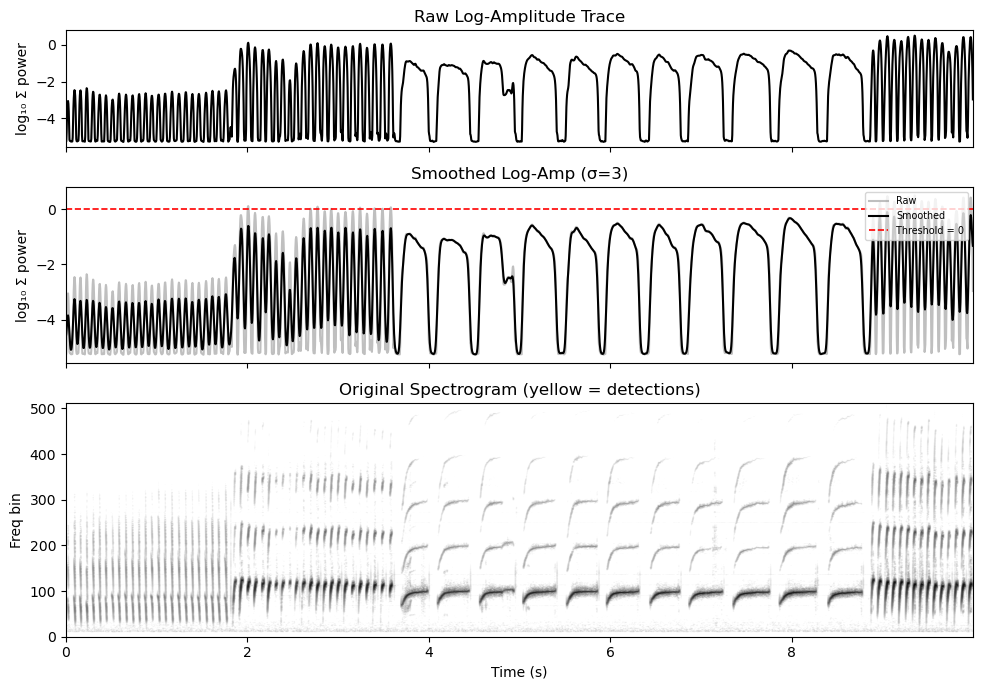


No detections above threshold.


In [80]:
#!/usr/bin/env python
# -*- coding: utf‑8 -*-
"""
Visualise a spectrogram stored in an .npz file and detect song by applying
smoothing + threshold directly to the log‑amplitude trace.

Required .npz keys
    s : 2‑D ndarray  (freq × time)           spectrogram values
Optional keys
    f : 1‑D ndarray  frequency axis (Hz)
    t : 1‑D ndarray  time axis (s)

If 't' is missing, supply `segment_duration` so the code can build a time axis.
"""

from pathlib import Path
from typing import Union, List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ── helper: build intervals from a boolean mask ─────────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray) -> List[Tuple[float, float]]:
    spans: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, flag in enumerate(mask):
        if flag and not in_run:
            in_run, start = True, times[idx]
        elif not flag and in_run:
            spans.append((start, times[idx]));  in_run = False
    if in_run:
        spans.append((start, times[-1]))
    return spans

# ── main routine ────────────────────────────────────────────────────────────
def plot_npz_logamp_panels(
        npz_path: Union[str, Path],
        segment_duration: Optional[float] = None,  # deduced from 't' if present
        smoothing_sigma: float = 3,
        log_threshold: float = -1.0,
    ) -> List[Tuple[float, float]]:
    """Generate 3 synced panels and return detected (start, end) intervals."""
    npz_path = Path(npz_path).expanduser()
    if npz_path.suffix.lower() != ".npz":
        raise ValueError("Only .npz files are supported.")

    # ── load data ──────────────────────────────────────────────────────────
    with np.load(npz_path, allow_pickle=True) as npz:
        S_raw = npz["s"]
        f = npz["f"] if "f" in npz.files else np.arange(S_raw.shape[0])
        t = npz["t"] if "t" in npz.files else None

    # Derive / validate time axis
    if t is None:
        if segment_duration is None:
            raise ValueError("Provide segment_duration if 't' axis is absent.")
        n_times = S_raw.shape[1]
        t = np.linspace(0, segment_duration, n_times, endpoint=False)
    else:
        if segment_duration is None:
            segment_duration = t[-1] + (t[1] - t[0])

    # Convert dB → linear if needed
    eps = np.finfo(float).eps
    S_lin = 10 ** (S_raw / 10) if np.any(S_raw < 0) else S_raw

    # ── log‑amplitude trace & smoothing ───────────────────────────────────
    log_amp    = np.log10(S_lin.sum(axis=0) + eps)
    log_amp_sm = gaussian_filter1d(log_amp, sigma=smoothing_sigma)
    detections = log_amp_sm > log_threshold
    det_intervals = mask_to_intervals(detections, t)

    # ── plotting (3 panels) ───────────────────────────────────────────────
    fig, axs = plt.subplots(
        3, 1, figsize=(10, 7), sharex=True,
        gridspec_kw=dict(height_ratios=[1, 1.5, 2])
    )

    # 1) raw log‑amp
    axs[0].plot(t, log_amp, color="black")
    axs[0].set_ylabel("log₁₀ Σ power")
    axs[0].set_title("Raw Log‑Amplitude Trace")

    # 2) smoothed log‑amp with threshold
    axs[1].plot(t, log_amp,    color="grey", alpha=0.5, label="Raw")
    axs[1].plot(t, log_amp_sm, color="black",            label="Smoothed")
    axs[1].axhline(log_threshold, color="red", ls="--", lw=1.2,
                   label=f"Threshold = {log_threshold}")
    for s_int, e_int in det_intervals:
        axs[1].axvspan(s_int, e_int, color="yellow", alpha=0.3)
    axs[1].set_ylabel("log₁₀ Σ power")
    axs[1].set_title(f"Smoothed Log‑Amp (σ={smoothing_sigma})")
    axs[1].legend(fontsize="x-small", loc="upper right")

    # 3) original spectrogram
    S_norm = (S_raw - S_raw.min()) / (S_raw.max() - S_raw.min() + eps)
    axs[2].imshow(
        S_norm, origin="lower", aspect="auto",
        extent=[t[0], t[-1], f[0], f[-1]],
        cmap="binary"
    )
    for s_int, e_int in det_intervals:
        axs[2].axvspan(s_int, e_int, color="yellow", alpha=0.3)
    axs[2].set_ylabel("Freq bin")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_title("Original Spectrogram (yellow = detections)")

    plt.tight_layout()
    plt.show()

    # console report
    if det_intervals:
        print("\nDetected intervals (s):")
        for s_int, e_int in det_intervals:
            print(f"  {s_int:7.3f} – {e_int:7.3f}")
    else:
        print("\nNo detections above threshold.")
    return det_intervals

# ── example call ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    plot_npz_logamp_panels(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/llb3_0439_2018_04_25_05_59_56_segment_0.npz",
        segment_duration=10,     # supply if 't' axis missing in file
        smoothing_sigma=3,       # Gaussian σ (samples)
        log_threshold=0        # dB value after smoothing
    )


# Generate a .json file with the amplitude values for every .npz file in a folder:

In [20]:
#!/usr/bin/env python3
"""
Batch saver: smoothed log‑amplitude trace + ground‑truth song mask
-----------------------------------------------------------------

For each .npz file in FOLDER_PATH this script:

1. Reconstructs a time axis (uses stored 't' if present, otherwise assumes the
   whole file spans SEGMENT_DURATION seconds).
2. Builds a log‑amplitude trace (log10 of the sum across frequency bins).
3. Smooths that trace with a Gaussian (σ = SMOOTHING_SIGMA samples).
4. Retrieves the ground‑truth 'song' mask.
5. Saves, for every file, a JSON record with:
      • file_name              : <file name>
      • log_amp_time           : list of time points (seconds)
      • smoothed_log_amp       : list of smoothed log‑amp values
      • song_mask              : list of 0/1 flags
      • groundtruth_intervals  : [[start, stop], …]   (seconds)

The JSON file is written one level **above** the .npz folder:
    <folder name>_logamp_groundtruth.json
"""

from pathlib import Path
import json
from typing import Union, Optional, List, Dict

import numpy as np
from scipy.ndimage import gaussian_filter1d

# ────────────────────────────────────────────────────────────────────
# CONFIG – edit only FOLDER_PATH unless you need different params
# ────────────────────────────────────────────────────────────────────
FOLDER_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs"   # ← paste your folder path here

SEGMENT_DURATION = 10          # seconds if no 't' vector stored
SMOOTHING_SIGMA  = 3           # Gaussian σ (samples) for log‑amp smoothing
NPZ_KEY_SPECTRO  = "s"
NPZ_KEY_SONG     = "song"


# ────────────────────────────────────────────────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray) -> List[List[float]]:
    """Boolean mask → list of [start, stop] intervals (seconds)."""
    padded = np.concatenate(([False], mask, [False]))
    diff   = np.diff(padded.astype(int))
    starts = np.where(diff ==  1)[0]
    stops  = np.where(diff == -1)[0]
    return [[float(times[s]), float(times[e-1])] for s, e in zip(starts, stops)]


def process_npz(npz_path: Path) -> Optional[Dict]:
    """Return a JSON‑ready dict for one .npz file (None if keys missing)."""
    with np.load(npz_path, allow_pickle=True) as npz:
        if NPZ_KEY_SPECTRO not in npz or NPZ_KEY_SONG not in npz:
            print(f"⚠️  {npz_path.name} missing required keys – skipped")
            return None

        S_db  = npz[NPZ_KEY_SPECTRO]          # shape = (freq, time)
        song  = npz[NPZ_KEY_SONG].astype(bool)
        n_freqs, n_times = S_db.shape

        # ---- time axis -------------------------------------------------
        if "t" in npz:
            t = np.asarray(npz["t"], dtype=float)
            seg_dur = t[-1] + (t[1] - t[0])
        else:
            seg_dur = SEGMENT_DURATION
            t = np.linspace(0, seg_dur, n_times, endpoint=False)

        # ---- log‑amplitude trace --------------------------------------
        eps     = np.finfo(float).eps
        S_lin   = 10 ** (S_db / 10)           # dB → linear power
        log_amp = np.log10(S_lin.sum(axis=0) + eps)
        log_amp_sm = gaussian_filter1d(log_amp, sigma=SMOOTHING_SIGMA)

        return {
            "file_name"            : npz_path.name,
            "log_amp_time"         : t.tolist(),
            "smoothed_log_amp"     : log_amp_sm.tolist(),
            "song_mask"            : song.astype(int).tolist(),
            "groundtruth_intervals": mask_to_intervals(song, t),
        }


def process_folder(folder_path: Union[str, Path]) -> Path:
    """Process every .npz in `folder_path` and write one JSON summary."""
    folder = Path(folder_path).expanduser().resolve()
    if not folder.is_dir():
        raise NotADirectoryError(folder)

    records: List[Dict] = []
    for npz_file in sorted(folder.glob("*.npz")):
        rec = process_npz(npz_file)
        if rec:
            records.append(rec)

    if not records:
        raise RuntimeError("No usable .npz files were found")

    out_json = folder.with_name(f"{folder.name}_logamp_groundtruth.json")
    with out_json.open("w", encoding="utf‑8") as fh:
        json.dump(records, fh, indent=2)

    print(f"✅  Wrote {len(records)} entries → {out_json}")
    return out_json


# ────────────────────────────────────────────────────────────────────
# Run the extractor
# ────────────────────────────────────────────────────────────────────
process_folder(FOLDER_PATH)


✅  Wrote 6 entries → /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_logamp_groundtruth.json


PosixPath('/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_logamp_groundtruth.json')

# Calculate the z-scored amplitude instead:

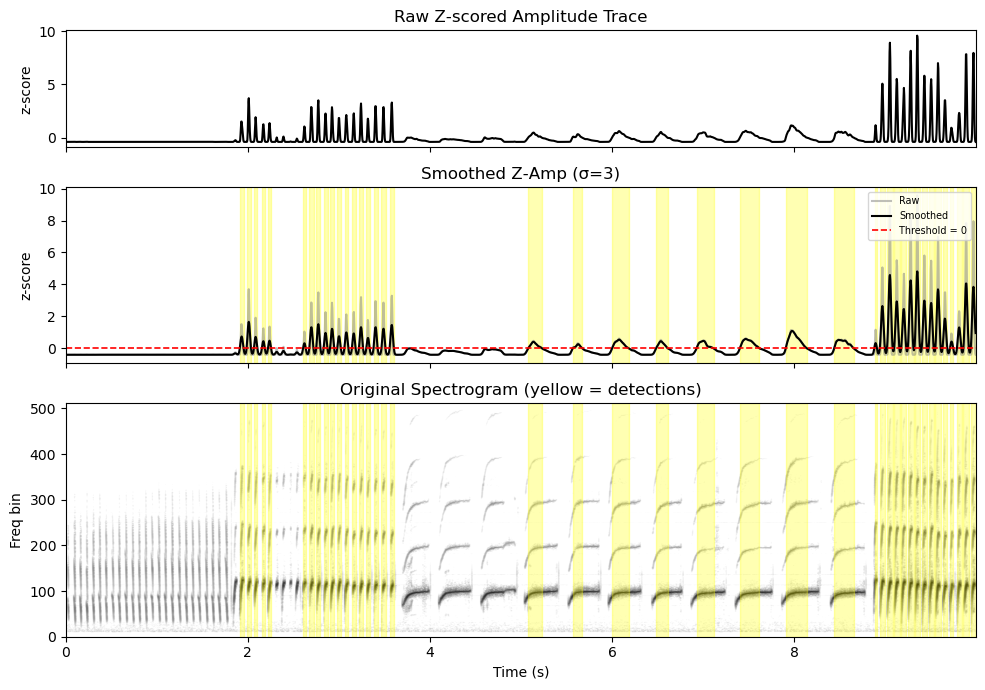


Detected intervals (s):
    1.911 –   1.954
    1.986 –   2.037
    2.069 –   2.104
    2.155 –   2.187
    2.222 –   2.258
    2.608 –   2.636
    2.675 –   2.723
    2.750 –   2.797
    2.833 –   2.876
    2.904 –   2.951
    2.983 –   3.022
    3.061 –   3.105
    3.144 –   3.184
    3.223 –   3.266
    3.302 –   3.341
    3.381 –   3.428
    3.467 –   3.515
    3.558 –   3.605
    5.083 –   5.229
    5.575 –   5.674
    6.005 –   6.186
    6.489 –   6.615
    6.931 –   7.116
    7.407 –   7.620
    7.912 –   8.140
    8.444 –   8.656
    8.885 –   8.913
    8.944 –   8.999
    9.023 –   9.086
    9.102 –   9.161
    9.180 –   9.236
    9.251 –   9.314
    9.326 –   9.389
    9.405 –   9.464
    9.480 –   9.539
    9.555 –   9.614
    9.634 –   9.685
    9.716 –   9.752
    9.791 –   9.842
    9.862 –   9.925
    9.945 –   9.996


In [93]:
#!/usr/bin/env python3
# -*- coding: utf‑8 -*-
"""
Visualise a spectrogram stored in an .npz file and detect song by applying
smoothing + threshold directly to the **z‑scored amplitude** trace.
"""

from pathlib import Path
from typing import Union, List, Tuple, Optional

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# ── helper: mask → [start, stop] list ───────────────────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray) -> List[Tuple[float, float]]:
    spans: List[Tuple[float, float]] = []
    in_run, start = False, 0.0
    for idx, flag in enumerate(mask):
        if flag and not in_run:
            in_run, start = True, times[idx]
        elif not flag and in_run:
            spans.append((start, times[idx]));  in_run = False
    if in_run:
        spans.append((start, times[-1]))
    return spans

# ── main routine ───────────────────────────────────────────────────────────
def plot_npz_zamp_panels(
        npz_path: Union[str, Path],
        segment_duration: Optional[float] = None,  # deduced from 't' if present
        smoothing_sigma: float = 3,
        z_threshold: float = 3.0,                  # threshold in z‑score units
    ) -> List[Tuple[float, float]]:
    """Plot 3 synced panels and return detected (start, end) intervals."""
    npz_path = Path(npz_path).expanduser()
    if npz_path.suffix.lower() != ".npz":
        raise ValueError("Only .npz files are supported.")

    # ── load data ────────────────────────────────────────────────────────
    with np.load(npz_path, allow_pickle=True) as npz:
        S_raw = npz["s"]
        f = npz["f"] if "f" in npz.files else np.arange(S_raw.shape[0])
        t = npz["t"] if "t" in npz.files else None

    # Derive / validate time axis
    if t is None:
        if segment_duration is None:
            raise ValueError("Provide segment_duration if 't' axis is absent.")
        n_times = S_raw.shape[1]
        t = np.linspace(0, segment_duration, n_times, endpoint=False)
    else:
        if segment_duration is None:
            segment_duration = t[-1] + (t[1] - t[0])

    # Convert dB → linear if needed
    S_lin = 10 ** (S_raw / 10) if np.any(S_raw < 0) else S_raw

    # ── linear‑amplitude trace (sum across freq) & z‑scoring ────────────
    amp_trace = S_lin.sum(axis=0)                       # linear magnitude
    mu, sigma = amp_trace.mean(), amp_trace.std()
    if sigma == 0:
        raise RuntimeError("Amplitude trace has zero variance; z‑score undefined.")
    z_amp     = (amp_trace - mu) / sigma
    z_amp_sm  = gaussian_filter1d(z_amp, sigma=smoothing_sigma)

    detections    = z_amp_sm > z_threshold
    det_intervals = mask_to_intervals(detections, t)

    # ── plotting (3 panels) ─────────────────────────────────────────────
    fig, axs = plt.subplots(
        3, 1, figsize=(10, 7), sharex=True,
        gridspec_kw=dict(height_ratios=[1, 1.5, 2])
    )

    # 1) raw z‑amp
    axs[0].plot(t, z_amp, color="black")
    axs[0].set_ylabel("z‑score")
    axs[0].set_title("Raw Z‑scored Amplitude Trace")

    # 2) smoothed z‑amp with threshold
    axs[1].plot(t, z_amp,   color="grey", alpha=0.5, label="Raw")
    axs[1].plot(t, z_amp_sm, color="black",           label="Smoothed")
    axs[1].axhline(z_threshold, color="red", ls="--", lw=1.2,
                   label=f"Threshold = {z_threshold}")
    for s_int, e_int in det_intervals:
        axs[1].axvspan(s_int, e_int, color="yellow", alpha=0.3)
    axs[1].set_ylabel("z‑score")
    axs[1].set_title(f"Smoothed Z‑Amp (σ={smoothing_sigma})")
    axs[1].legend(fontsize="x-small", loc="upper right")

    # 3) original spectrogram (normalised 0–1 for display)
    eps = np.finfo(float).eps
    S_norm = (S_raw - S_raw.min()) / (S_raw.max() - S_raw.min() + eps)
    axs[2].imshow(
        S_norm, origin="lower", aspect="auto",
        extent=[t[0], t[-1], f[0], f[-1]],
        cmap="binary"
    )
    for s_int, e_int in det_intervals:
        axs[2].axvspan(s_int, e_int, color="yellow", alpha=0.3)
    axs[2].set_ylabel("Freq bin")
    axs[2].set_xlabel("Time (s)")
    axs[2].set_title("Original Spectrogram (yellow = detections)")

    plt.tight_layout()
    plt.show()

    # console report
    if det_intervals:
        print("\nDetected intervals (s):")
        for s_int, e_int in det_intervals:
            print(f"  {s_int:7.3f} – {e_int:7.3f}")
    else:
        print("\nNo detections above threshold.")
    return det_intervals

# ── example call ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    plot_npz_zamp_panels(
        "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs/llb3_0439_2018_04_25_05_59_56_segment_0.npz",
        segment_duration=10,   # needed if 't' axis missing
        smoothing_sigma=3,
        z_threshold=0     # in z‑score units
    )


## save the z-scored amplitude in a.json file:

In [94]:
#!/usr/bin/env python3
"""
Batch saver: smoothed **z‑scored amplitude** trace + ground‑truth song mask
--------------------------------------------------------------------------

For each .npz file in FOLDER_PATH this script:

1. Reconstructs a time axis (uses stored 't' if present, otherwise assumes the
   whole file spans SEGMENT_DURATION seconds).
2. Builds a linear‑amplitude trace (sum across frequency bins) and z‑scores it
   ((x‑μ)/σ).
3. Smooths the z‑scored trace with a Gaussian (σ = SMOOTHING_SIGMA samples).
4. Retrieves the ground‑truth 'song' mask.
5. Saves, for every file, a JSON record with:
      • file_name              : <file name>
      • z_amp_time             : list of time points (seconds)
      • smoothed_z_amp         : list of smoothed z‑scored amplitudes
      • song_mask              : list of 0/1 flags
      • groundtruth_intervals  : [[start, stop], …]   (seconds)

The JSON file is written one level **above** the .npz folder:
    <folder name>_zamp_groundtruth.json
"""

from pathlib import Path
import json
from typing import Union, Optional, List, Dict

import numpy as np
from scipy.ndimage import gaussian_filter1d

# ────────────────────────────────────────────────────────────────────
# CONFIG – edit only FOLDER_PATH unless you need different params
# ────────────────────────────────────────────────────────────────────
FOLDER_PATH = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs"  # ← paste your folder path

SEGMENT_DURATION = 10          # seconds if no 't' vector stored
SMOOTHING_SIGMA  = 3           # Gaussian σ (samples) for z‑amp smoothing
NPZ_KEY_SPECTRO  = "s"
NPZ_KEY_SONG     = "song"


# ────────────────────────────────────────────────────────────────────
def mask_to_intervals(mask: np.ndarray,
                      times: np.ndarray) -> List[List[float]]:
    """Boolean mask → list of [start, stop] intervals (seconds)."""
    padded = np.concatenate(([False], mask, [False]))
    diff   = np.diff(padded.astype(int))
    starts = np.where(diff ==  1)[0]
    stops  = np.where(diff == -1)[0]
    return [[float(times[s]), float(times[e-1])] for s, e in zip(starts, stops)]


def process_npz(npz_path: Path) -> Optional[Dict]:
    """Return a JSON‑ready dict for one .npz file (None if keys missing)."""
    with np.load(npz_path, allow_pickle=True) as npz:
        if NPZ_KEY_SPECTRO not in npz or NPZ_KEY_SONG not in npz:
            print(f"⚠️  {npz_path.name} missing required keys – skipped")
            return None

        S_db  = npz[NPZ_KEY_SPECTRO]          # shape = (freq, time)
        song  = npz[NPZ_KEY_SONG].astype(bool)
        n_freqs, n_times = S_db.shape

        # ---- time axis -------------------------------------------------
        if "t" in npz:
            t = np.asarray(npz["t"], dtype=float)
            seg_dur = t[-1] + (t[1] - t[0])
        else:
            seg_dur = SEGMENT_DURATION
            t = np.linspace(0, seg_dur, n_times, endpoint=False)

        # ---- build z‑scored amplitude trace ---------------------------
        S_lin      = 10 ** (S_db / 10) if np.any(S_db < 0) else S_db
        amp_trace  = S_lin.sum(axis=0)                 # linear magnitude
        mu, sigma  = amp_trace.mean(), amp_trace.std()
        if sigma == 0:
            print(f"⚠️  {npz_path.name}: zero variance, skipped")
            return None
        z_amp      = (amp_trace - mu) / sigma
        z_amp_sm   = gaussian_filter1d(z_amp, sigma=SMOOTHING_SIGMA)

        return {
            "file_name"            : npz_path.name,
            "z_amp_time"           : t.tolist(),
            "smoothed_z_amp"       : z_amp_sm.tolist(),
            "song_mask"            : song.astype(int).tolist(),
            "groundtruth_intervals": mask_to_intervals(song, t),
        }


def process_folder(folder_path: Union[str, Path]) -> Path:
    """Process every .npz in `folder_path` and write one JSON summary."""
    folder = Path(folder_path).expanduser().resolve()
    if not folder.is_dir():
        raise NotADirectoryError(folder)

    records: List[Dict] = []
    for npz_file in sorted(folder.glob("*.npz")):
        rec = process_npz(npz_file)
        if rec:
            records.append(rec)

    if not records:
        raise RuntimeError("No usable .npz files were found")

    out_json = folder.with_name(f"{folder.name}_zamp_groundtruth.json")
    with out_json.open("w", encoding="utf‑8") as fh:
        json.dump(records, fh, indent=2)

    print(f"✅  Wrote {len(records)} entries → {out_json}")
    return out_json


# ────────────────────────────────────────────────────────────────────
# Run the extractor
# ────────────────────────────────────────────────────────────────────
process_folder(FOLDER_PATH)


✅  Wrote 6 entries → /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_zamp_groundtruth.json


PosixPath('/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_zamp_groundtruth.json')

# Combine the log-ampltidue and modulated amplitude 2 .json files:

In [29]:
from pathlib import Path
import json
from typing import Dict, List, Optional

# ── helper: load & index by file_name ────────────────────────────────────
def _load_by_name(json_path: str) -> Dict[str, dict]:
    with open(json_path, "r", encoding="utf‑8") as fh:
        recs = json.load(fh)
    return {r["file_name"]: r for r in recs}

def combine_jsons(
    logamp_path: str,
    modband_path: str,
    out_path: Optional[str] = None,
) -> Path:
    """Merge the two JSON summaries *and* keep `smoothed_log_amp`."""
    logamp  = _load_by_name(logamp_path)
    modband = _load_by_name(modband_path)

    combined: List[dict] = []
    for fname in sorted(set(logamp) | set(modband)):
        rec: dict = {"file_name": fname}

        # ----- copy everything useful from the log‑amp record -----
        if fname in logamp:
            la = logamp[fname]
            for k in ("log_amp_time", "smoothed_log_amp",
                      "song_mask", "groundtruth_intervals"):
                rec[k] = la.get(k, [])
        else:
            print(f"⚠️  {fname} missing in log‑amp JSON")

        # ----- copy mod‑band info from the second record -----
        if fname in modband:
            mb = modband[fname]
            rec["mod_band_time"]  = mb.get("mod_band_time", [])
            rec["mod_band_power"] = mb.get("mod_band_power", [])
            # fall‑back for intervals if they were absent above
            rec.setdefault("groundtruth_intervals",
                           mb.get("groundtruth_intervals", []))
        else:
            print(f"⚠️  {fname} missing in mod‑band JSON")

        combined.append(rec)

    # ----- write output adjacent to log‑amp JSON unless user specifies -----
    if out_path is None:
        p       = Path(logamp_path).resolve()
        prefix  = p.stem.rsplit("_logamp_groundtruth", 1)[0]
        out_path = str(p.with_name(f"{prefix}_combined.json"))

    with open(out_path, "w", encoding="utf‑8") as fh:
        json.dump(combined, fh, indent=2)

    print(f"✅  Combined {len(combined)} entries → {out_path}")
    return Path(out_path)

combine_jsons(
    "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_logamp_groundtruth.json",
    "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_groundtruth_modband.json"
)


✅  Combined 6 entries → /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_combined.json


PosixPath('/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_combined.json')

## multipurpose code to combine all the records from the .json files into one:

In [95]:
from pathlib import Path
import json
from typing import Dict, List, Optional

# ── helper: load one JSON and index it by file_name ─────────────────────────
def _load_by_name(json_path: str) -> Dict[str, dict]:
    with open(json_path, "r", encoding="utf‑8") as fh:
        recs = json.load(fh)
    return {r["file_name"]: r for r in recs}

# ────────────────────────────────────────────────────────────────────────────
def combine_jsons(
    *json_paths: str,
    out_path: Optional[str] = None,
) -> Path:
    """
    Merge an arbitrary number of JSON summary files.

    Parameters
    ----------
    *json_paths : str
        One or more paths to JSON files.  Order matters: keys in later files
        override the same keys from earlier files when duplicates occur.
    out_path : str or None
        Where to write the combined JSON.  If None, a name is generated from
        the first input file (<prefix>_combined.json).

    Returns
    -------
    pathlib.Path
        Path to the written combined JSON.
    """
    if len(json_paths) < 2:
        raise ValueError("Provide at least two JSON paths to combine.")

    # -------- load each file into a dict{file_name: record} ---------------
    sources: List[Dict[str, dict]] = [_load_by_name(p) for p in json_paths]

    # -------- union of all file names -------------------------------------
    all_files = sorted(set().union(*(src.keys() for src in sources)))
    combined: List[dict] = []

    for fname in all_files:
        rec: dict = {"file_name": fname}

        # iterate over the source dicts *in the given order*
        for src in sources:
            if fname not in src:
                continue
            for key, val in src[fname].items():
                if key == "file_name":
                    continue
                # later files overwrite earlier ones
                rec[key] = val
        combined.append(rec)

    # -------- choose output path ------------------------------------------
    if out_path is None:
        first = Path(json_paths[0]).resolve()
        prefix = first.stem.split("_")[0]          # crude but practical
        out_path = str(first.with_name(f"{prefix}_combined.json"))

    with open(out_path, "w", encoding="utf‑8") as fh:
        json.dump(combined, fh, indent=2)

    print(f"✅  Combined {len(combined)} entries → {out_path}")
    return Path(out_path)


# ── Example call ───────────────────────────────────────────────────────────
combine_jsons(
    "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_logamp_groundtruth.json",
    "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_groundtruth_modband.json",
    "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_zamp_groundtruth.json"
)


✅  Combined 6 entries → /Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_combined.json


PosixPath('/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_combined.json')

Interpolate literally means “fill in the missing points between known points.”
In data analysis you use interpolation when you have one quantity measured at certain times (or positions) and you want to estimate what that quantity would be at other times for which you have no direct measurement.
np.interp looks at the two log‑amp samples that straddle each t_mod point and linearly estimates the value in between.

Loaded 6 combined entries from sample_combined.json


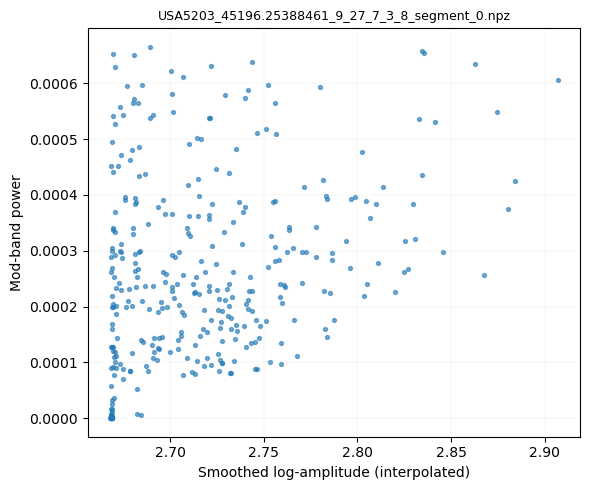

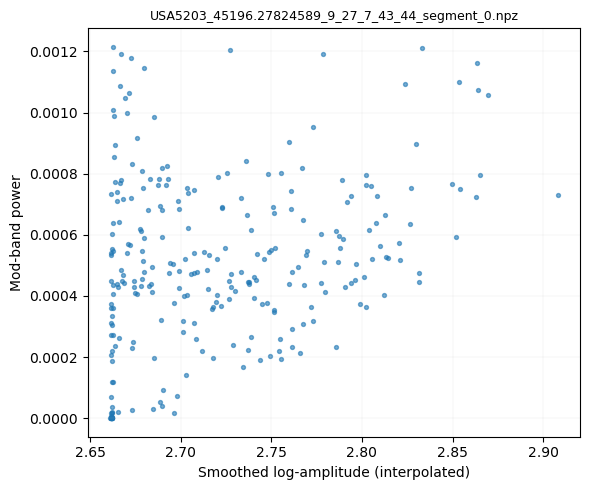

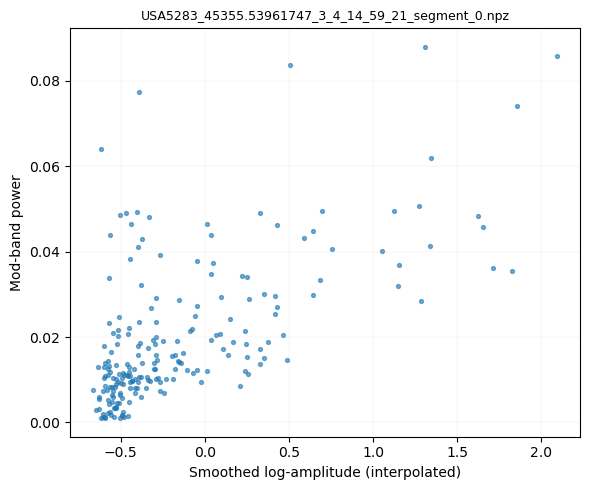

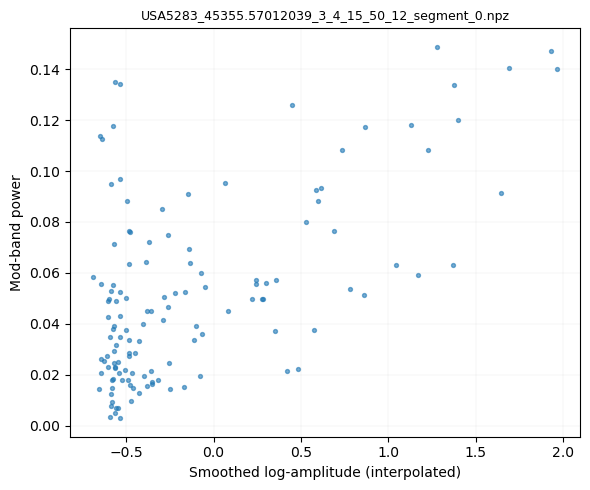

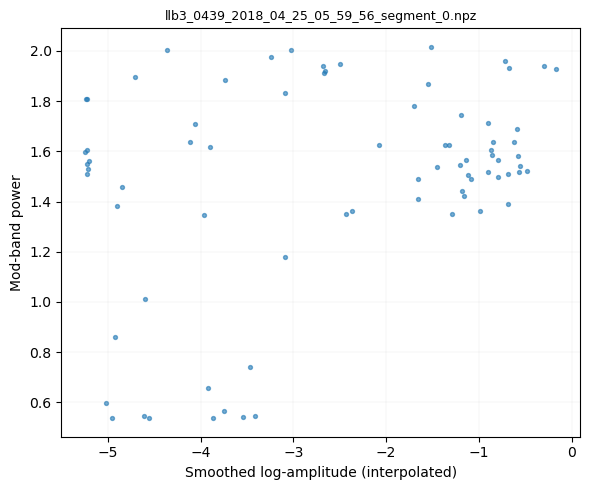

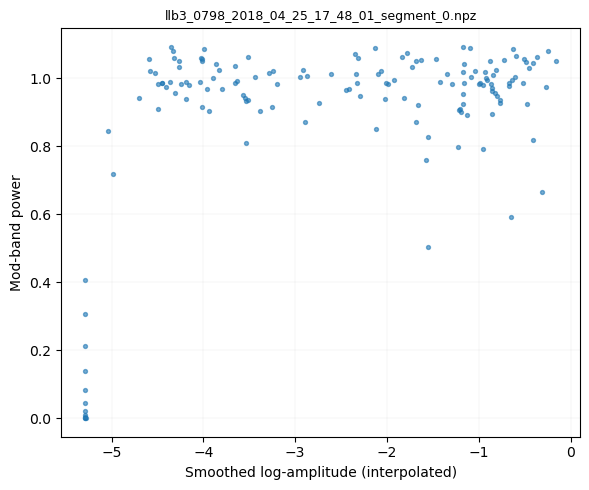

In [96]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------------
# 1)  Point to your combined JSON
COMBINED_JSON = Path(
    "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_combined.json"
).expanduser().resolve()

# ------------------------------------------------------------------
# 2)  Load the records
records = json.loads(COMBINED_JSON.read_text(encoding="utf‑8"))
print(f"Loaded {len(records)} combined entries from {COMBINED_JSON.name}")

# ------------------------------------------------------------------
# 3)  For every file, align the two traces and plot
for rec in records:
    fname = rec["file_name"]

    # ---- grab arrays ----
    t_log   = np.asarray(rec["log_amp_time"],      dtype=float)
    log_amp = np.asarray(rec["smoothed_log_amp"],  dtype=float)
    t_mod   = np.asarray(rec["mod_band_time"],     dtype=float)
    mod_pow = np.asarray(rec["mod_band_power"],    dtype=float)

    # ---- skip if any piece missing ----
    if t_log.size == 0 or t_mod.size == 0:
        print(f"⚠️  {fname}: missing time axes – skipped")
        continue

    # ---- interpolate log‑amp onto the mod‑band time grid ----
    log_interp = np.interp(t_mod, t_log, log_amp)

    # ---- scatter plot ----
    plt.figure(figsize=(6, 5))
    plt.scatter(log_interp, mod_pow, s=8, alpha=0.6)
    plt.xlabel("Smoothed log‑amplitude (interpolated)")
    plt.ylabel("Mod‑band power")
    plt.title(fname, fontsize=9)
    plt.grid(True, lw=0.3, alpha=0.3)
    plt.tight_layout()
    plt.show()


Loaded 6 combined entries from sample_combined.json


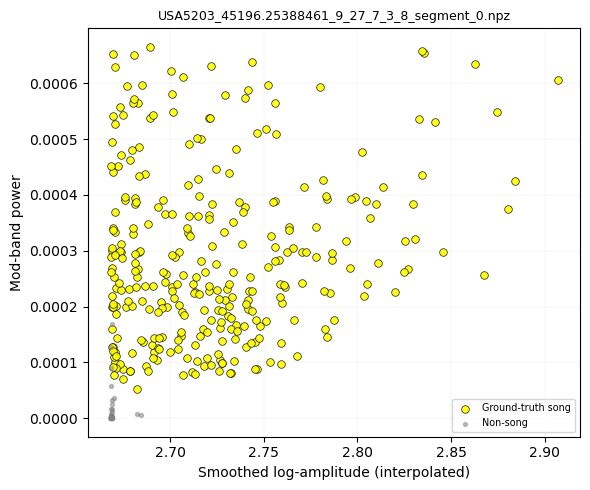

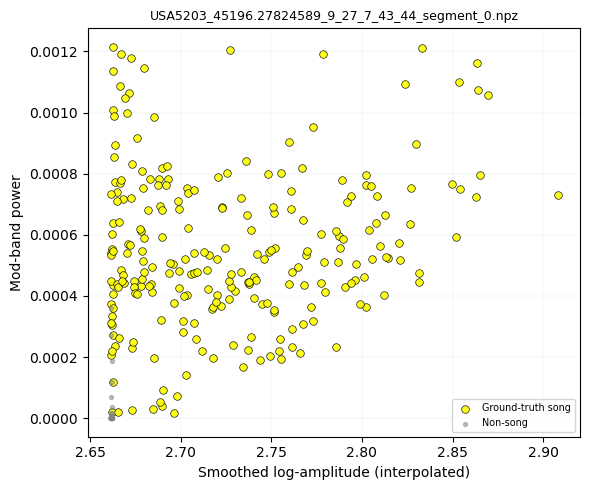

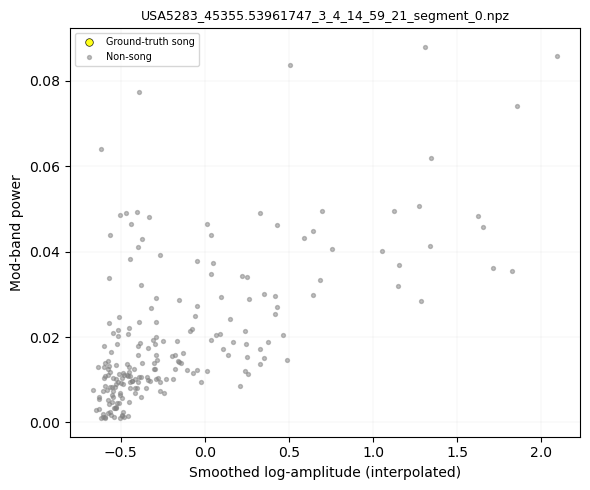

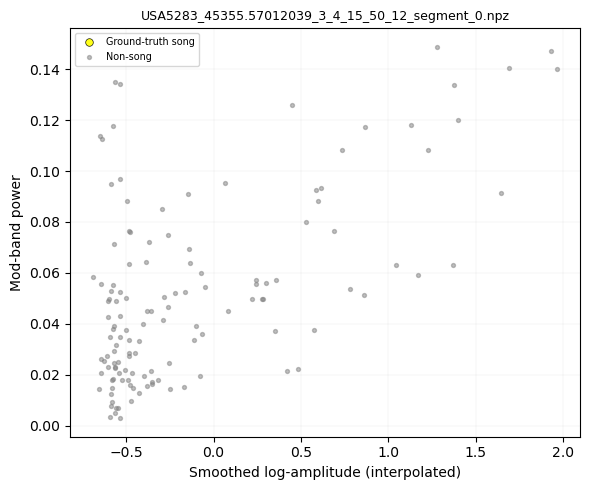

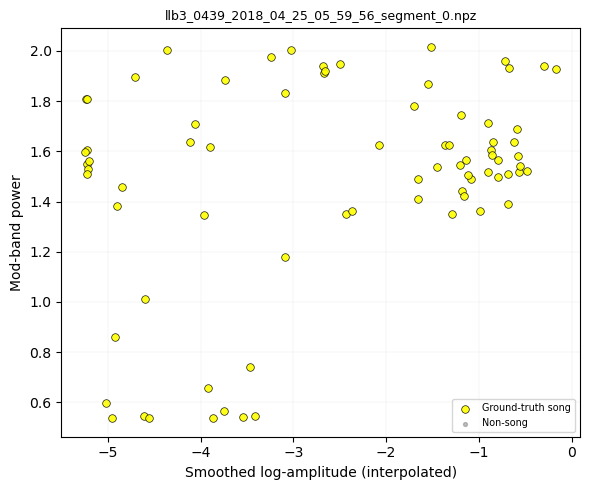

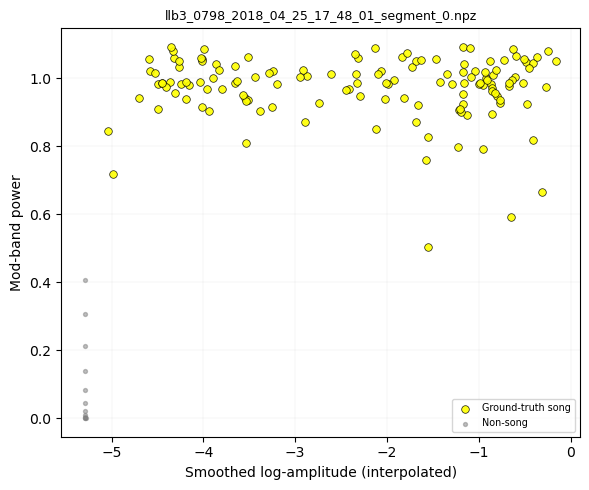

In [97]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------------
# 1)  Point to your combined JSON
COMBINED_JSON = Path(
    "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_combined.json"
).expanduser().resolve()

# ------------------------------------------------------------------
# 2)  Load the records
records = json.loads(COMBINED_JSON.read_text(encoding="utf‑8"))
print(f"Loaded {len(records)} combined entries from {COMBINED_JSON.name}")

# ------------------------------------------------------------------
# ------------------------------------------------------------------
# 3)  For every file, align the two traces and plot
for rec in records:
    fname = rec["file_name"]

    # ---- grab arrays ----
    t_log   = np.asarray(rec["log_amp_time"],     dtype=float)
    log_amp = np.asarray(rec["smoothed_log_amp"], dtype=float)
    t_mod   = np.asarray(rec["mod_band_time"],    dtype=float)
    mod_pow = np.asarray(rec["mod_band_power"],   dtype=float)

    # skip if any piece missing
    if t_log.size == 0 or t_mod.size == 0:
        print(f"⚠️  {fname}: missing time axes – skipped")
        continue

    # ---- interpolate log‑amp onto the mod‑band time grid ----
    log_interp = np.interp(t_mod, t_log, log_amp)

    # ---- create a mask for points inside ground‑truth intervals ----
    in_song = np.zeros_like(t_mod, dtype=bool)
    for start, stop in rec["groundtruth_intervals"]:
        in_song |= (t_mod >= start) & (t_mod <= stop)

    # ---- scatter plot ----
    plt.figure(figsize=(6, 5))

    # song points: yellow face, black edge
    plt.scatter(
        log_interp[in_song],
        mod_pow[in_song],
        s=30,
        facecolor="yellow",
        edgecolor="black",
        linewidth=0.5,
        alpha=0.9,
        label="Ground‑truth song"
    )

    # non‑song points: light grey
    plt.scatter(
        log_interp[~in_song],
        mod_pow[~in_song],
        s=8,
        color="grey",
        alpha=0.5,
        label="Non‑song"
    )

    plt.xlabel("Smoothed log‑amplitude (interpolated)")
    plt.ylabel("Mod‑band power")
    plt.title(fname, fontsize=9)
    plt.grid(True, lw=0.3, alpha=0.3)
    plt.legend(fontsize="x-small")
    plt.tight_layout()
    plt.show()



Loaded 6 combined entries from sample_GV_groundtruth_npzs_combined.json


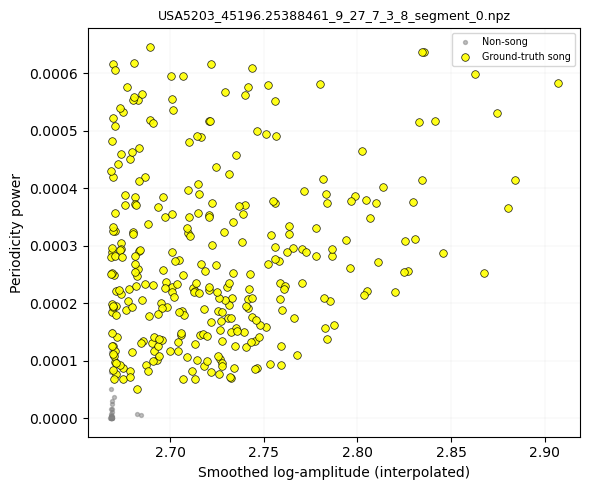

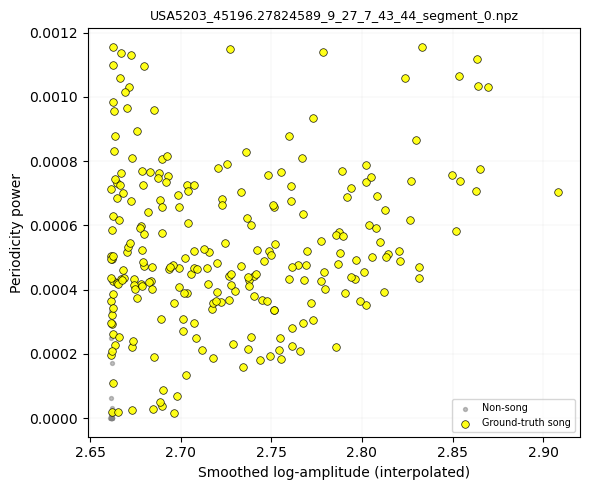

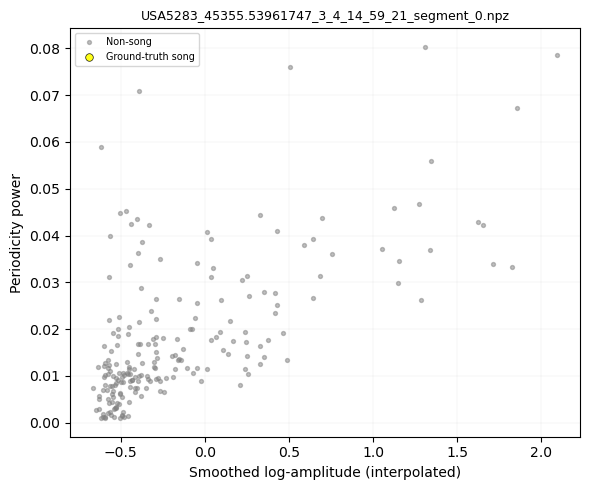

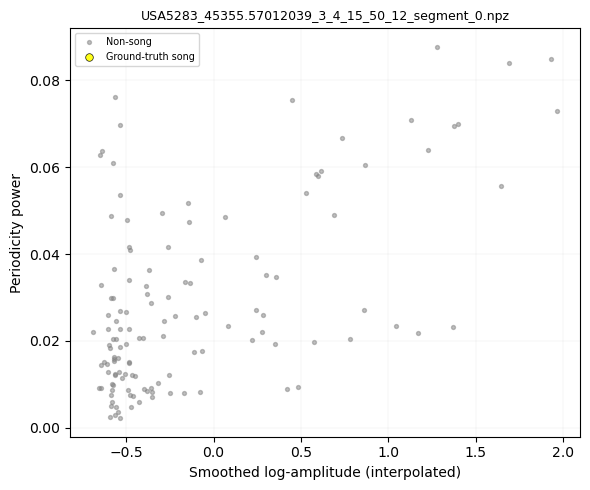

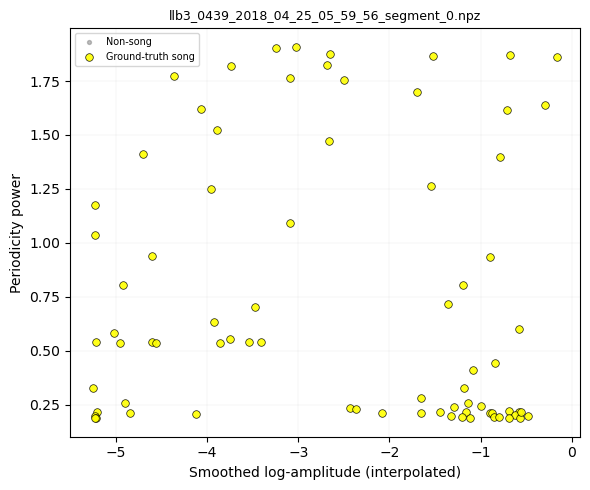

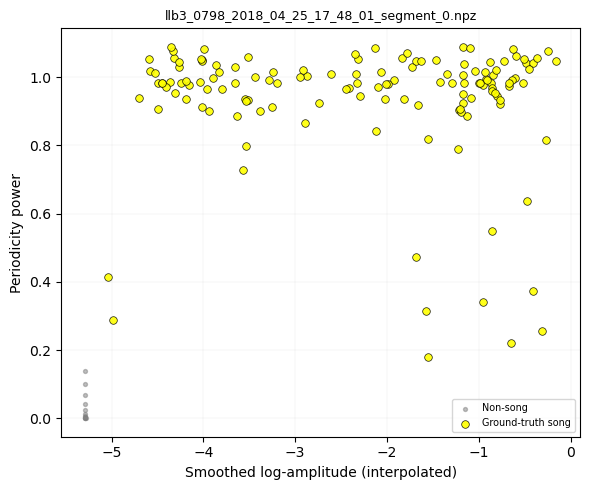

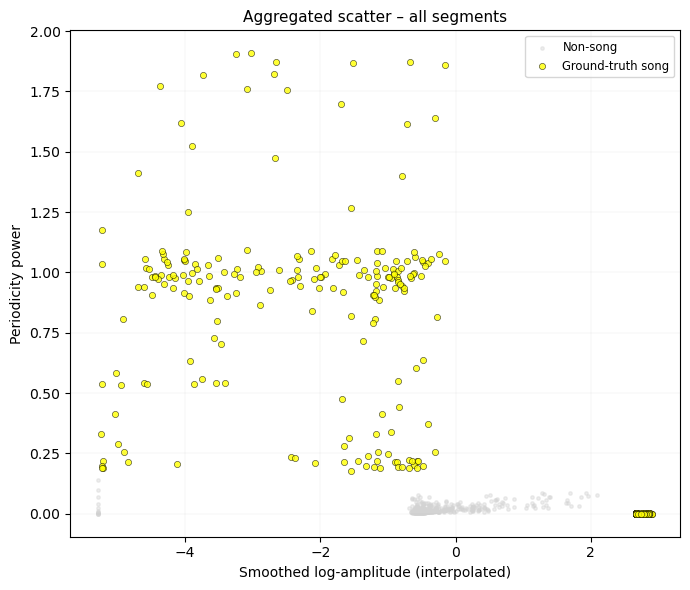

In [100]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ──────────────────────────────────────────────────────────────
# 1.  Path to the combined JSON
COMBINED_JSON = Path(
    "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_combined.json"
).expanduser().resolve()

# ──────────────────────────────────────────────────────────────
# 2.  Load the records
records = json.loads(COMBINED_JSON.read_text(encoding="utf‑8"))
print(f"Loaded {len(records)} combined entries from {COMBINED_JSON.name}")

# ──────────────────────────────────────────────────────────────
# 3.  Prepare accumulators for the pooled plot
all_x_song, all_y_song       = [], []
all_x_nonsong, all_y_nonsong = [], []

# ──────────────────────────────────────────────────────────────
# 4.  Loop through segments: plot individually and collect points
for rec in records:
    fname      = rec["file_name"]
    t_log      = np.asarray(rec["log_amp_time"],     dtype=float)
    log_amp    = np.asarray(rec["smoothed_log_amp"], dtype=float)
    t_mod      = np.asarray(rec["mod_band_time"],    dtype=float)
    mod_pow    = np.asarray(rec["mod_band_power"],   dtype=float)

    if t_log.size == 0 or t_mod.size == 0:
        print(f"⚠️  {fname}: missing time axes – skipped")
        continue

    # ---- interpolate log‑amp onto the mod‑band grid ----
    log_interp = np.interp(t_mod, t_log, log_amp)

    # ---- ground‑truth mask ----
    in_song = np.zeros_like(t_mod, dtype=bool)
    for start, stop in rec["groundtruth_intervals"]:
        in_song |= (t_mod >= start) & (t_mod <= stop)

    # ---- collect points for pooled plot ----
    all_x_song.append(log_interp[in_song])
    all_y_song.append(mod_pow[in_song])
    all_x_nonsong.append(log_interp[~in_song])
    all_y_nonsong.append(mod_pow[~in_song])

    # ---- per‑file scatter ----
    plt.figure(figsize=(6, 5))
    plt.scatter(log_interp[~in_song], mod_pow[~in_song],
                s=8, color="grey", alpha=0.5, label="Non‑song")
    plt.scatter(log_interp[in_song],  mod_pow[in_song],
                s=30, facecolor="yellow", edgecolor="black",
                linewidth=0.5, alpha=0.9, label="Ground‑truth song")
    plt.xlabel("Smoothed log‑amplitude (interpolated)")
    plt.ylabel("Periodicity power")
    plt.title(fname, fontsize=9)
    plt.grid(True, lw=0.3, alpha=0.3)
    plt.legend(fontsize="x-small")
    plt.tight_layout()
    plt.show()

# ──────────────────────────────────────────────────────────────
# 5.  Make aggregated scatter‑plot
if all_x_song:
    # concatenate lists of arrays
    x_song   = np.concatenate(all_x_song)
    y_song   = np.concatenate(all_y_song)
    x_non    = np.concatenate(all_x_nonsong)
    y_non    = np.concatenate(all_y_nonsong)

    plt.figure(figsize=(7, 6))
    plt.scatter(x_non, y_non, s=6, color="lightgrey", alpha=0.4, label="Non‑song")
    plt.scatter(x_song, y_song, s=20, facecolor="yellow",
                edgecolor="black", linewidth=0.4, alpha=0.8,
                label="Ground‑truth song")
    plt.xlabel("Smoothed log‑amplitude (interpolated)")
    plt.ylabel("Periodicity power")
    plt.title("Aggregated scatter – all segments", fontsize=11)
    plt.grid(True, lw=0.3, alpha=0.3)
    plt.legend(fontsize="small")
    plt.tight_layout()
    plt.show()
else:
    print("No valid segments to pool.")


# Graph the z-scored amplitude versus the mod-band power instead:

Loaded 6 combined entries from sample_GV_groundtruth_npzs_combined.json


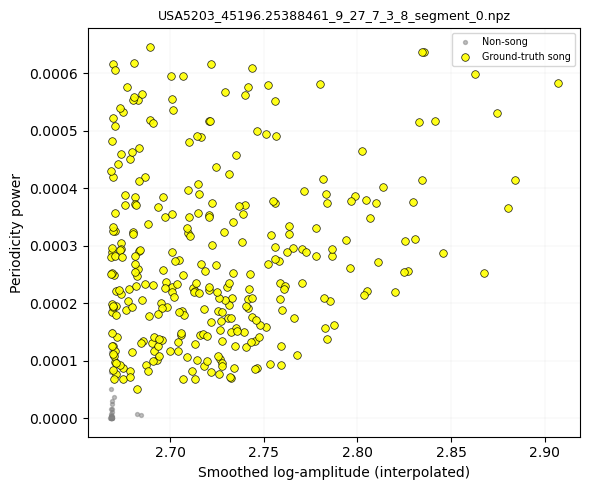

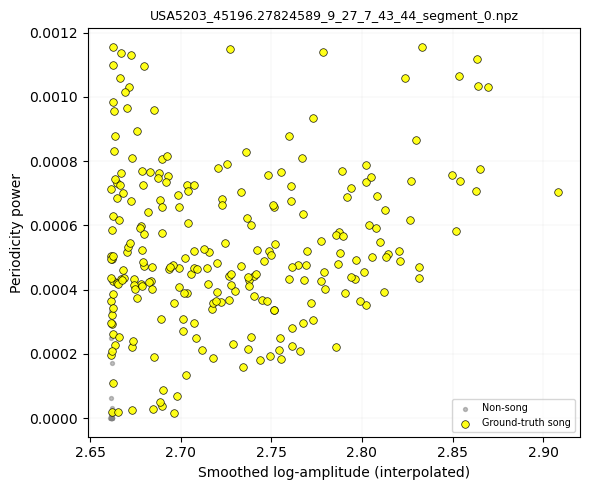

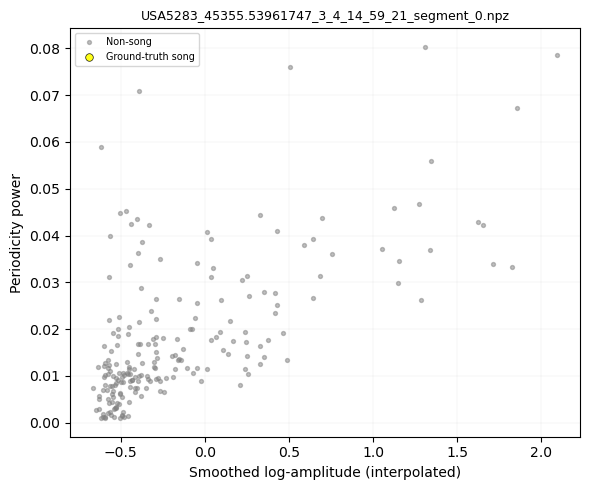

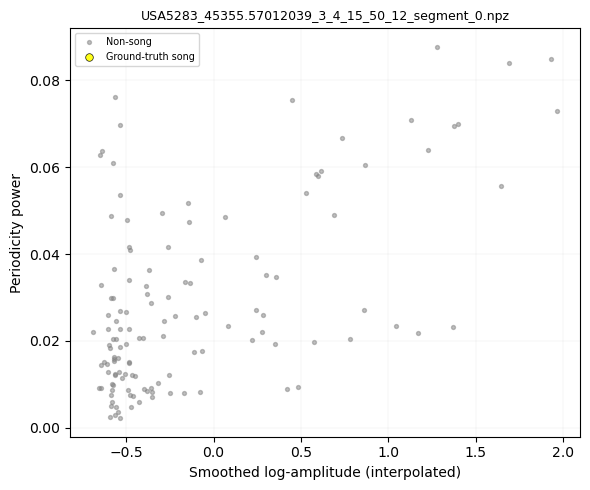

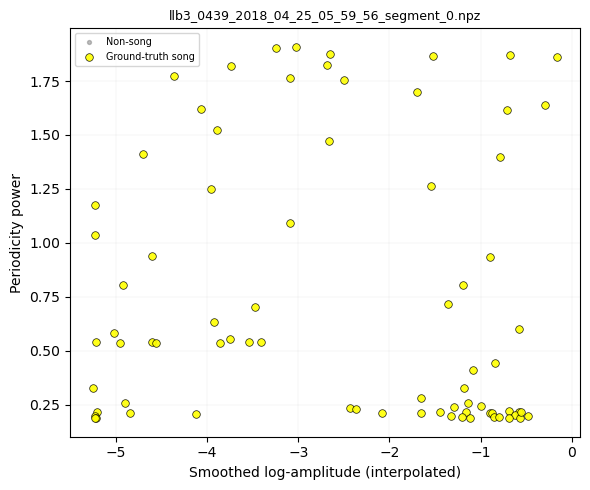

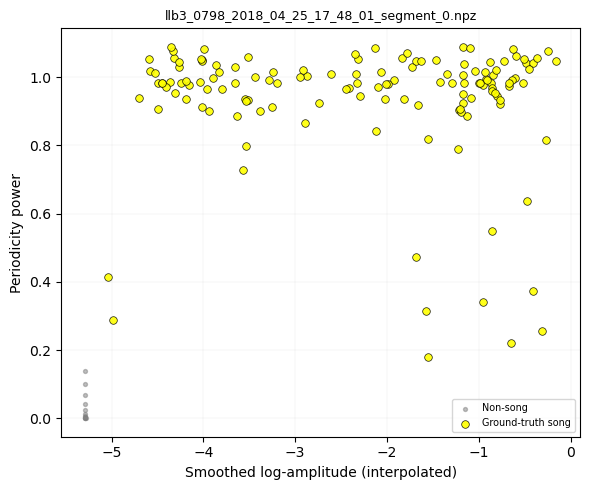

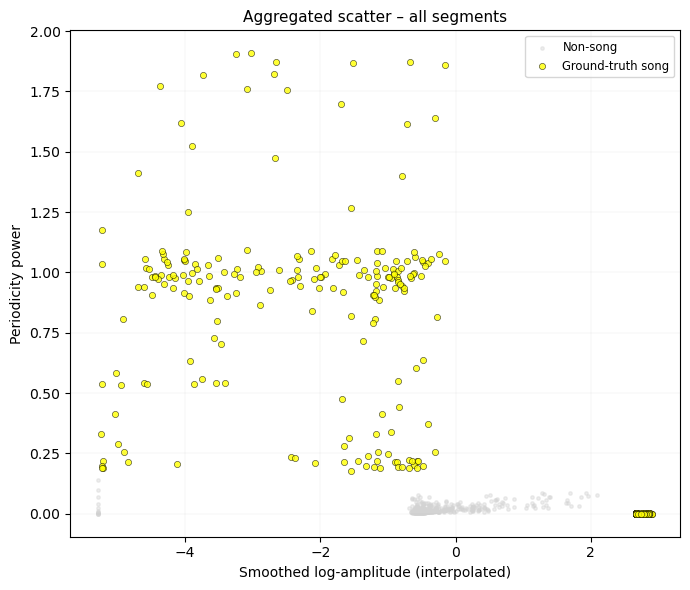

In [101]:
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ------------------------------------------------------------
COMBINED_JSON = Path(
    "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/sample_GV_groundtruth_npzs_combined.json"
).expanduser().resolve()

records = json.loads(COMBINED_JSON.read_text(encoding="utf‑8"))
print(f"Loaded {len(records)} combined entries from {COMBINED_JSON.name}")

# accumulators for pooled plot
all_x_song, all_y_song, all_x_nonsong, all_y_nonsong = [], [], [], []

def get_amp_arrays(rec: dict):
    """Return (time, value, label) for amplitude trace in a record."""
    if "z_amp_time" in rec and "smoothed_z_amp" in rec:
        return (rec["z_amp_time"], rec["smoothed_z_amp"],
                "Smoothed z‑score amplitude (interpolated)")
    if "log_amp_time" in rec and "smoothed_log_amp" in rec:
        return (rec["log_amp_time"], rec["smoothed_log_amp"],
                "Smoothed log‑amplitude (interpolated)")
    return None, None, None   # nothing usable

# ------------------------------------------------------------
for rec in records:
    fname = rec["file_name"]

    amp_time, amp_vals, x_label = get_amp_arrays(rec)
    if amp_time is None:
        print(f"⚠️  {fname}: no amplitude trace found – skipped")
        continue

    # arrays
    t_amp  = np.asarray(amp_time, dtype=float)
    amp_sm = np.asarray(amp_vals, dtype=float)
    t_mod  = np.asarray(rec.get("mod_band_time", []),  dtype=float)
    mod_pow = np.asarray(rec.get("mod_band_power", []), dtype=float)

    if t_amp.size == 0 or t_mod.size == 0:
        print(f"⚠️  {fname}: missing time axes – skipped")
        continue

    # align grids
    amp_interp = np.interp(t_mod, t_amp, amp_sm)

    # build ground‑truth mask
    in_song = np.zeros_like(t_mod, dtype=bool)
    for start, stop in rec.get("groundtruth_intervals", []):
        in_song |= (t_mod >= start) & (t_mod <= stop)

    # collect for pooled plot
    all_x_song.append(amp_interp[in_song]);   all_y_song.append(mod_pow[in_song])
    all_x_nonsong.append(amp_interp[~in_song]); all_y_nonsong.append(mod_pow[~in_song])

    # per‑file plot
    plt.figure(figsize=(6, 5))
    plt.scatter(amp_interp[~in_song], mod_pow[~in_song],
                s=8, color="grey", alpha=0.5, label="Non‑song")
    plt.scatter(amp_interp[in_song],  mod_pow[in_song],
                s=30, facecolor="yellow", edgecolor="black",
                linewidth=0.5, alpha=0.9, label="Ground‑truth song")
    plt.xlabel(x_label)
    plt.ylabel("Periodicity power")
    plt.title(fname, fontsize=9)
    plt.grid(True, lw=0.3, alpha=0.3)
    plt.legend(fontsize="x-small")
    plt.tight_layout()
    plt.show()

# pooled scatter
if all_x_song:
    x_song = np.concatenate(all_x_song);  y_song = np.concatenate(all_y_song)
    x_non  = np.concatenate(all_x_nonsong); y_non = np.concatenate(all_y_nonsong)

    plt.figure(figsize=(7, 6))
    plt.scatter(x_non, y_non, s=6, color="lightgrey", alpha=0.4, label="Non‑song")
    plt.scatter(x_song, y_song, s=20, facecolor="yellow",
                edgecolor="black", linewidth=0.4, alpha=0.8,
                label="Ground‑truth song")
    plt.xlabel(x_label)
    plt.ylabel("Periodicity power")
    plt.title("Aggregated scatter – all segments", fontsize=11)
    plt.grid(True, lw=0.3, alpha=0.3)
    plt.legend(fontsize="small")
    plt.tight_layout()
    plt.show()
else:
    print("No valid segments to pool.")
